In [1]:
import numpy as np
import tritonclient.grpc as grpcclient
from tritonclient.utils import np_to_triton_dtype, triton_to_np_dtype
import matplotlib.pyplot as plt
import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 12)

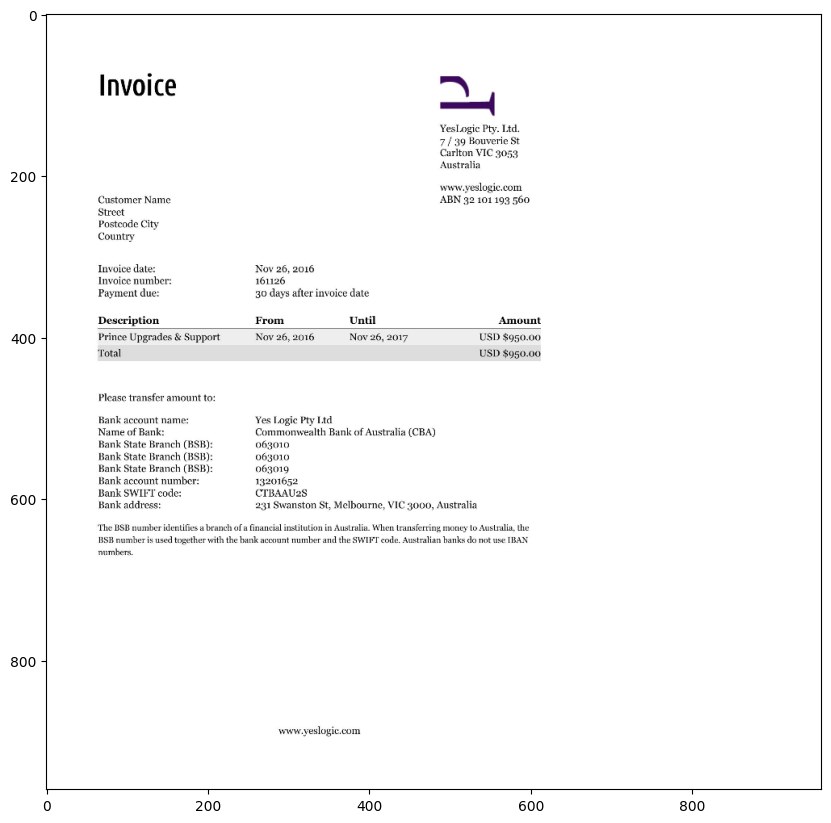

In [2]:
img = cv2.imread("./invoice.jpg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Renew_size and pad image to 960x960

new_size = 960

if img.shape[0] > img.shape[1]:
    img = cv2.resize(img, (int(new_size * img.shape[1] / img.shape[0]), new_size))
    pad = np.ones((new_size, new_size - img.shape[1], 3), dtype=np.uint8) * 255
    img = np.concatenate([img, pad], axis=1)
else:
    img = cv2.resize(img, (new_size, int(new_size * img.shape[0] / img.shape[1])))
    pad = np.ones((new_size - img.shape[0], new_size, 3), dtype=np.uint8) * 255
    img = np.concatenate([img, pad], axis=0)

plt.imshow(img)

tensor = img.astype(np.float32)


# Normalize image with 122.67891434, 116.66876762, 104.00698793
mean = np.array([122.67891434, 116.66876762, 104.00698793])
tensor = (tensor - mean) / 255.0

# Convert to CHW
tensor = np.transpose(tensor, (2, 0, 1))

# Add batch dimension
tensor = np.expand_dims(tensor, axis=0)

tensor = tensor.astype(np.float32)

In [3]:
triton_client = grpcclient.InferenceServerClient(url="localhost:8001")

In [4]:
model_metadata = triton_client.get_model_metadata(model_name="db")
model_metadata

name: "db"
versions: "1"
platform: "tensorrt_plan"
inputs {
  name: "input"
  datatype: "FP32"
  shape: 1
  shape: 3
  shape: -1
  shape: -1
}
outputs {
  name: "out"
  datatype: "FP32"
  shape: -1
  shape: -1
}

In [5]:
inputs = [grpcclient.InferInput("input", tensor.shape, np_to_triton_dtype(tensor.dtype))]
inputs[0].set_data_from_numpy(tensor)

outputs = [grpcclient.InferRequestedOutput("out")]

response = triton_client.infer(
    "db",
    inputs,
    outputs=outputs,
)

In [6]:
out = response.as_numpy('out')

In [7]:
import cv2
import numpy as np
from shapely.geometry import Polygon
import pyclipper


class SegDetectorRepresenter:
    max_candidates = 1000
    dest = "binary"

    def __init__(self):
        self.min_size = 3
        self.scale_ratio = 0.4
        self.thresh = 0.3
        self.box_thresh = 0.3

    def represent(self, pred):

        segmentation = self.binarize(pred)

        return self.boxes_from_bitmap(pred, segmentation)

    def binarize(self, pred):
        return pred > self.thresh

    def boxes_from_bitmap(self, pred, bitmap):
        dest_width, dest_height = pred.shape
        height, width = bitmap.shape
        contours, _ = cv2.findContours(
            (bitmap * 255).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
        )
        num_contours = min(len(contours), self.max_candidates)
        boxes = np.zeros((num_contours, 4, 2), dtype=np.int64)
        scores = np.zeros((num_contours,), dtype=np.float32)

        for index in range(num_contours):
            contour = contours[index]
            points, sside = self.get_mini_boxes(contour)
            if sside < self.min_size:
                continue
            points = np.array(points)
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if self.box_thresh > score:
                continue

            box = self.unclip(points).reshape(-1, 1, 2)
            box, sside = self.get_mini_boxes(box)
            if sside < self.min_size + 2:
                continue
            box = np.array(box)
            if not isinstance(dest_width, int):
                dest_width = dest_width.item()
                dest_height = dest_height.item()

            box[:, 0] = np.clip(np.round(box[:, 0] / width * dest_width), 0, dest_width)
            box[:, 1] = np.clip(
                np.round(box[:, 1] / height * dest_height), 0, dest_height
            )
            boxes[index, :, :] = box.astype(np.int64)
            scores[index] = score
        return boxes, scores

    def unclip(self, box, unclip_ratio=1.5):
        poly = Polygon(box)
        distance = poly.area * unclip_ratio / poly.length
        offset = pyclipper.PyclipperOffset()
        offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        expanded = np.array(offset.Execute(distance))
        return expanded

    def get_mini_boxes(self, contour):
        bounding_box = cv2.minAreaRect(contour)
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_1, index_2, index_3, index_4 = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_1 = 0
            index_4 = 1
        else:
            index_1 = 1
            index_4 = 0
        if points[3][1] > points[2][1]:
            index_2 = 2
            index_3 = 3
        else:
            index_2 = 3
            index_3 = 2

        box = [points[index_1], points[index_2], points[index_3], points[index_4]]
        return box, min(bounding_box[1])

    def box_score_fast(self, bitmap, _box):
        h, w = bitmap.shape[:2]
        box = _box.copy()
        xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int64), 0, w - 1)
        xmax = np.clip(np.ceil(box[:, 0].max()).astype(np.int64), 0, w - 1)
        ymin = np.clip(np.floor(box[:, 1].min()).astype(np.int64), 0, h - 1)
        ymax = np.clip(np.ceil(box[:, 1].max()).astype(np.int64), 0, h - 1)

        mask = np.zeros((ymax - ymin + 1, xmax - xmin + 1), dtype=np.uint8)
        box[:, 0] = box[:, 0] - xmin
        box[:, 1] = box[:, 1] - ymin
        cv2.fillPoly(mask, box.reshape(1, -1, 2).astype(np.int64), 1)
        return cv2.mean(bitmap[ymin : ymax + 1, xmin : xmax + 1], mask)[0]


representer = SegDetectorRepresenter()

boxes, scores = representer.represent(out)

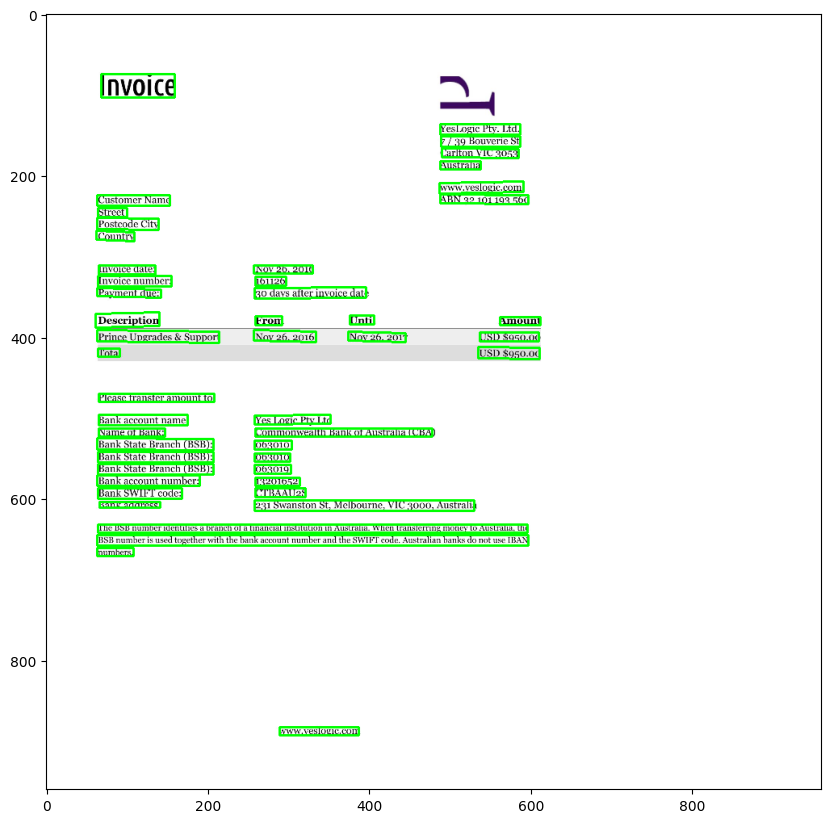

In [8]:
img_for_box = img.copy()

for box in boxes:
    cv2.polylines(img_for_box, [box], True, (0, 255, 0), 2)

plt.imshow(img_for_box)

